<a href="https://colab.research.google.com/github/mipypf/scej-mi/blob/develop/scej_mi_chapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MI領域で最もオーソドックスかつ使用頻度の高いテーブルデータタスクを題材にして、デモデータを用いたベースラインでの実例を扱う

### 使用するデータセットの参考文献
- Tamura, R. et al. Materials informatics approach to understand aluminum alloys. Sci Technol Adv Mater 540–551 (2020) doi:10.1080/14686996.2020.1791676

### データセットのダウンロード
- https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676#supplemental-material-section からtsta_a_1791676_sm7404.csvをダウンロード

### Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、tsta_a_1791676_sm7404.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

### ライブラリをインポート

In [3]:
! pip install japanize_matplotlib==1.1.3
! pip install adjustText==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=e0ff273798b0a5b2aec6a979310e77543369b629d52b0090deed511ac036d61c
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


In [4]:
import os
import warnings

warnings.filterwarnings("ignore")

import pickle

import japanize_matplotlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
import sklearn
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tqdm

print("matplotlib:", matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("tqdm:", tqdm.__version__)

from tqdm.notebook import tqdm

matplotlib: 3.10.0
numpy: 2.0.2
pandas: 2.2.2
seaborn: 0.13.2
scikit-learn: 1.6.1
tqdm: 4.67.1


In [5]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

### ファイルのコンフィグ情報を定義

In [6]:
class CFG:
    input_dir = INPUT_FILE_PATH
    output_dir = OUTPUT_FILE_PATH
    random_seed = 42
    exp_no = "exp000"

### データの読み込み

In [7]:
data = pd.read_csv(f"{CFG.input_dir}/tsta_a_1791676_sm7404.csv")
data

,ID,X,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 6005A BE,1,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,100,170,15
1,A 6005A BE,4,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,90,180,15
2,A 6005A BE,5,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,215,260,9
3,A 6005A BE,6,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,225,270,8
4,A 6005C BE,1,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.13,107,176,16
5,A 6005C BE,5,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.13,175,225,8
6,A 6005C BE,6,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.13,235,265,8
7,A 6060 BE,4,0.20,0.05,0.45,98.63,0.48,0.05,0.05,0.03,0.08,60,120,14
8,A 6060 BE,5,0.20,0.05,0.45,98.63,0.48,0.05,0.05,0.03,0.08,120,160,6
9,A 6060 BE,6,0.20,0.05,0.45,98.63,0.48,0.05,0.05,0.03,0.08,150,190,8


### EDA

##### データの列名を確認

In [8]:
columns = data.columns
columns

Index(['ID', 'X', 'Fe (wt%)', 'Mn (wt%)', 'Si (wt%)', 'Al (wt%)', 'Mg (wt%)',
       'Ti (wt%)', 'Cu (wt%)', 'Cr (wt%)', 'Zn (wt%)', '2% proof stress (Mpa)',
       'Tensile strength (Mpa)', 'Elongation (%)'],
      dtype='object')

##### データの欠損を確認

In [9]:
data.isnull().sum()

,0
ID,0
X,0
Fe (wt%),0
Mn (wt%),0
Si (wt%),0
Al (wt%),0
Mg (wt%),0
Ti (wt%),0
Cu (wt%),0
Cr (wt%),0


##### IDごとに個数をカウント

In [10]:
data['ID'].value_counts()

,count
ID,
A 6005A BE,4
A 6463 S,4
A 6063 BD,4
A 6005C BE,3
A 6060 BE,3
A 6262 BD,3
A 6061 BD,2
A 6061 P,2
A 6082 P,2


##### IDごとのXの値を可視化

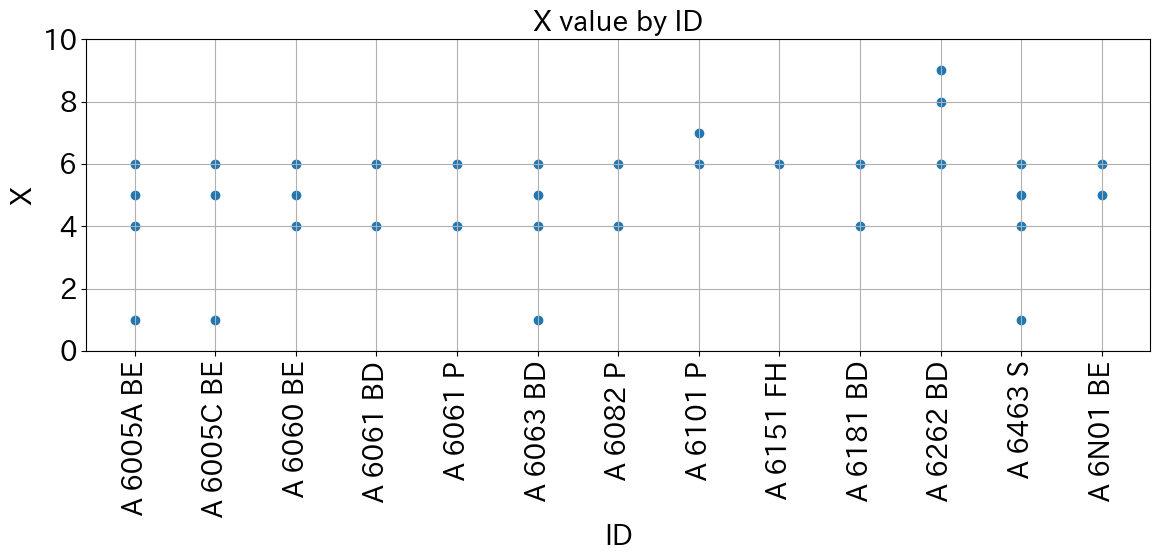

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(data["ID"], data["X"])
plt.xlabel("ID")
plt.ylabel("X")
plt.title("X value by ID")
plt.xticks(rotation=90)
plt.ylim(bottom=0)
plt.ylim(top=10)
plt.grid(True)
plt.tight_layout()
plt.show()

##### 2% proof stress (Mpa)のヒストグラムを作成

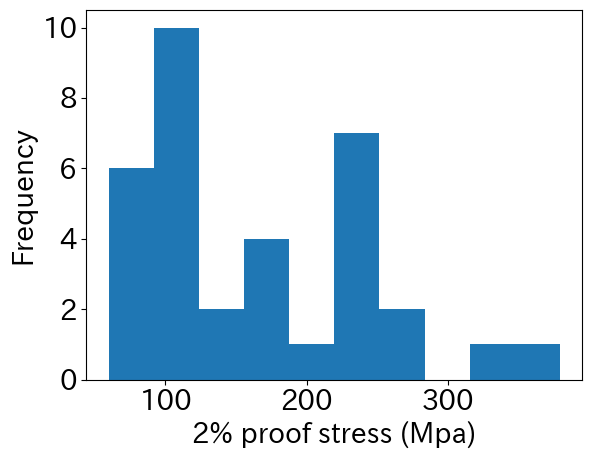

In [12]:
plt.hist(data["2% proof stress (Mpa)"])
plt.xlabel("2% proof stress (Mpa)")
plt.ylabel("Frequency")
plt.show()

### 使用する説明変数をリストとして定義

In [13]:
numeric_parameter_cols = [
    # 'ID',
    'X',
    'Fe (wt%)',
    'Mn (wt%)',
    'Si (wt%)',
    'Al (wt%)',
    'Mg (wt%)',
    'Ti (wt%)',
    'Cu (wt%)',
    'Cr (wt%)',
    'Zn (wt%)',
    # '2% proof stress (Mpa)',
    # 'Tensile strength (Mpa)',
    # 'Elongation (%)'
    ]

### 説明変数と目的変数の定義

In [14]:
train_X = data[numeric_parameter_cols]
objective_cols = ['2% proof stress (Mpa)']
train_Y = data[objective_cols]

### PLSRegressionを用いたLeave-one-outによる交差検証

0it [00:00, ?it/s]

Index([0], dtype='int64')
RMSE_train: 35.221474739634665
MAE_train: 28.872141874692915
R2_train: 0.8125660843414246
Index([1], dtype='int64')
RMSE_train: 34.4989018819869
MAE_train: 28.350538454327168
R2_train: 0.8189907980624062
Index([2], dtype='int64')
RMSE_train: 36.164332038335104
MAE_train: 29.73177957969094
R2_train: 0.8038862103413527
Index([3], dtype='int64')
RMSE_train: 36.8636982589853
MAE_train: 30.14035114244483
R2_train: 0.7951632906148984
Index([4], dtype='int64')
RMSE_train: 35.36310928453496
MAE_train: 28.94914423381102
R2_train: 0.8118137202218042
Index([5], dtype='int64')
RMSE_train: 36.673233323788395
MAE_train: 30.594007805835698
R2_train: 0.800605706862271
Index([6], dtype='int64')
RMSE_train: 36.9405506015282
MAE_train: 30.361056999813105
R2_train: 0.7930323721871967
Index([7], dtype='int64')
RMSE_train: 35.66093853467863
MAE_train: 29.350146746670827
R2_train: 0.8015307825038644
Index([8], dtype='int64')
RMSE_train: 36.53411264411822
MAE_train: 30.36942823606817

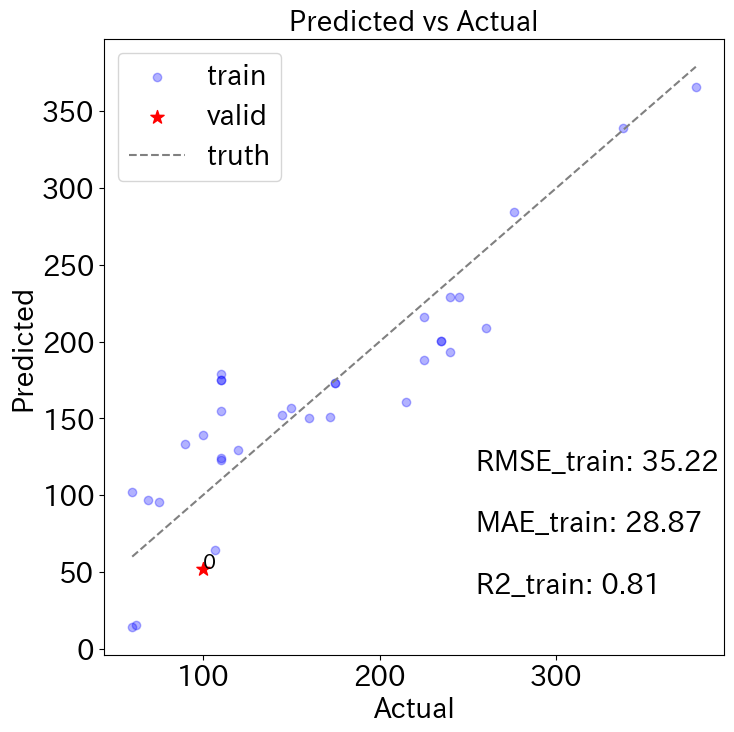

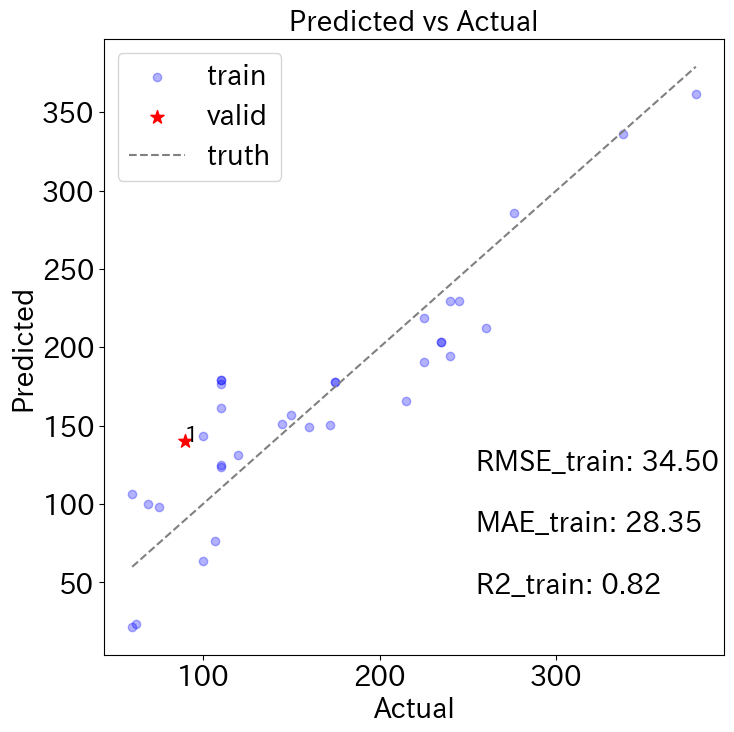

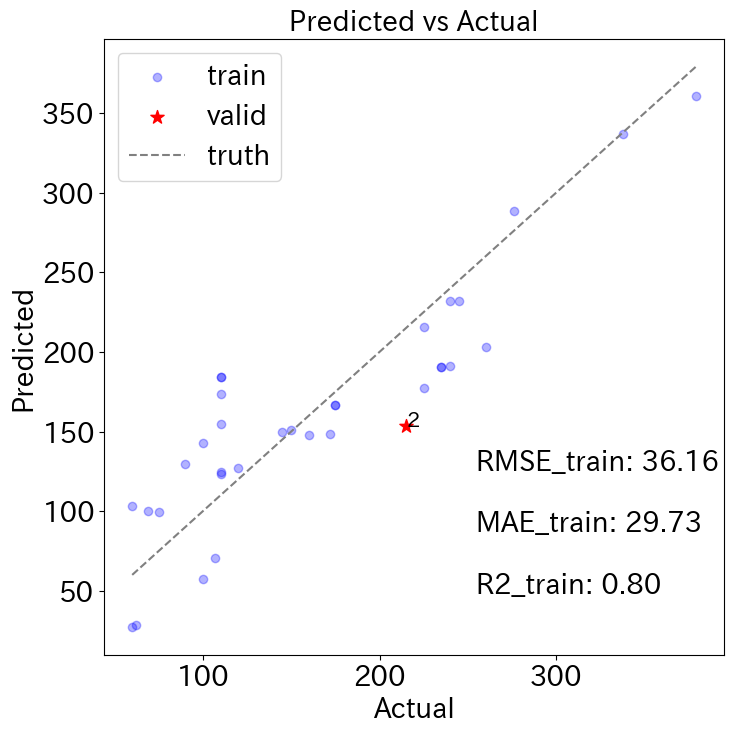

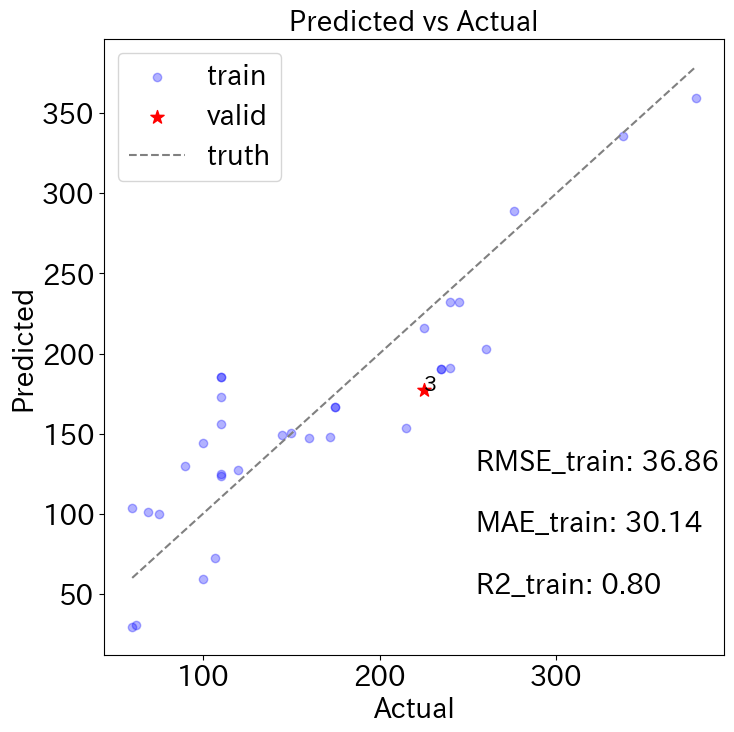

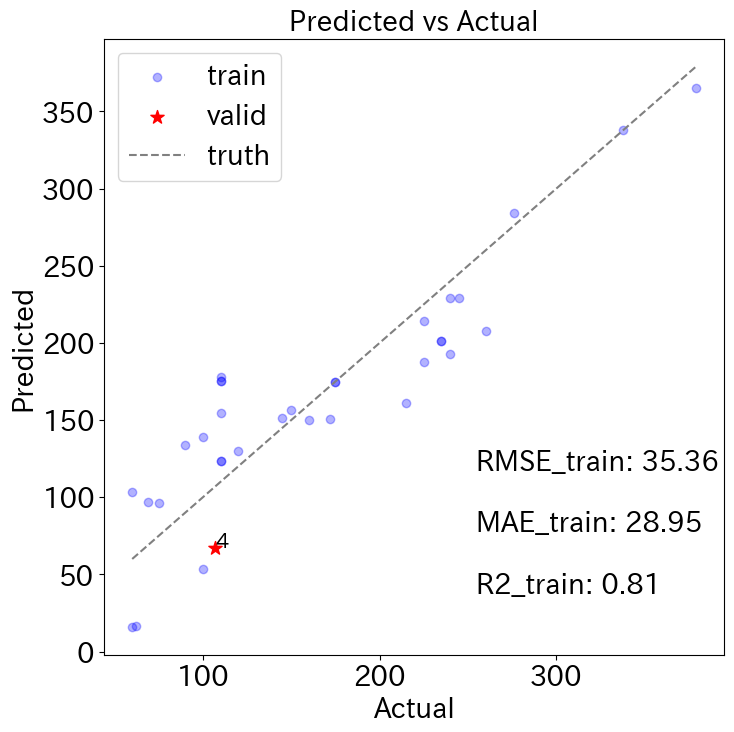

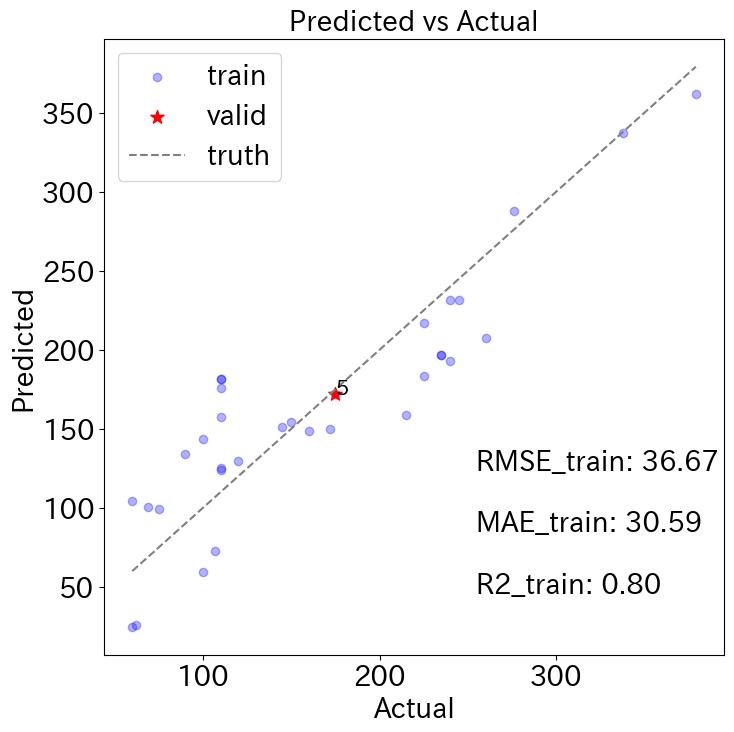

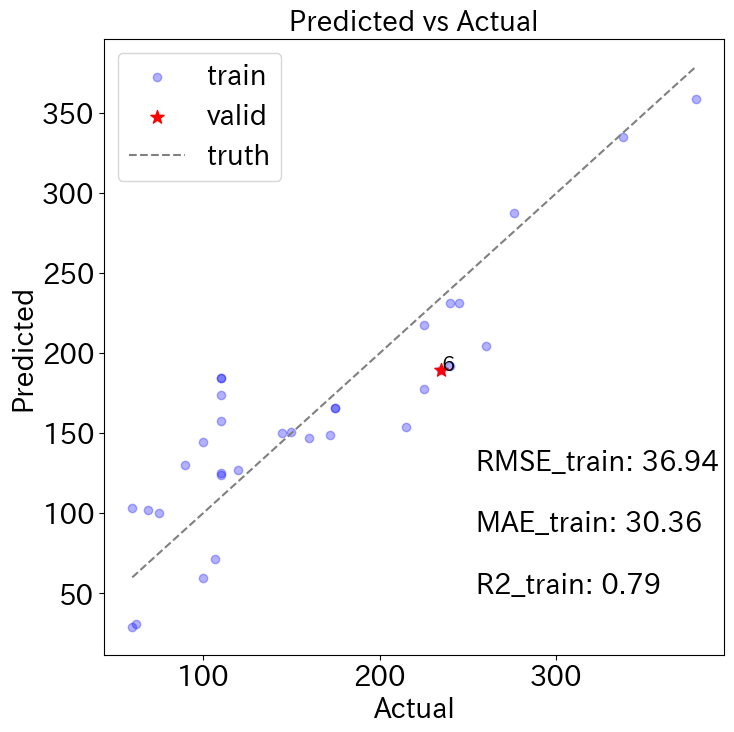

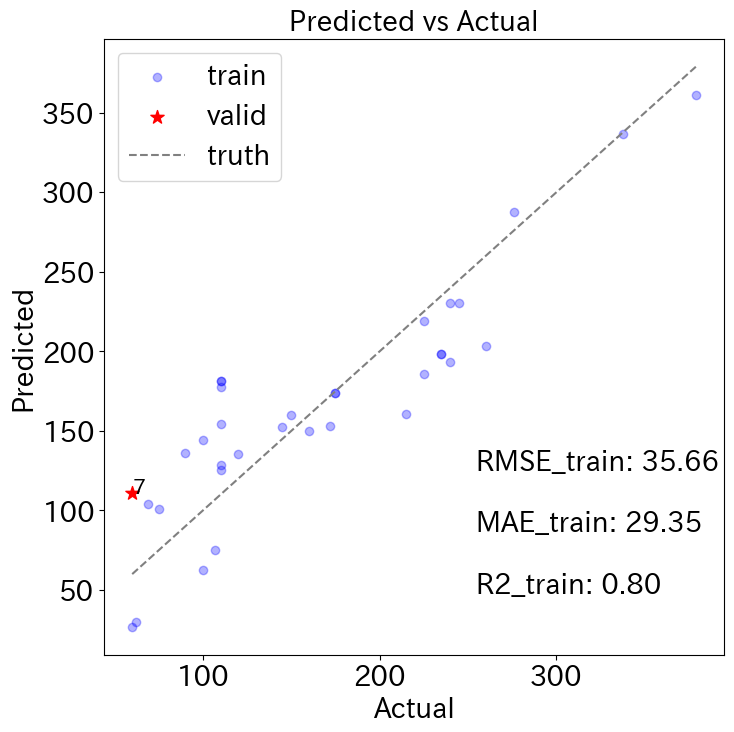

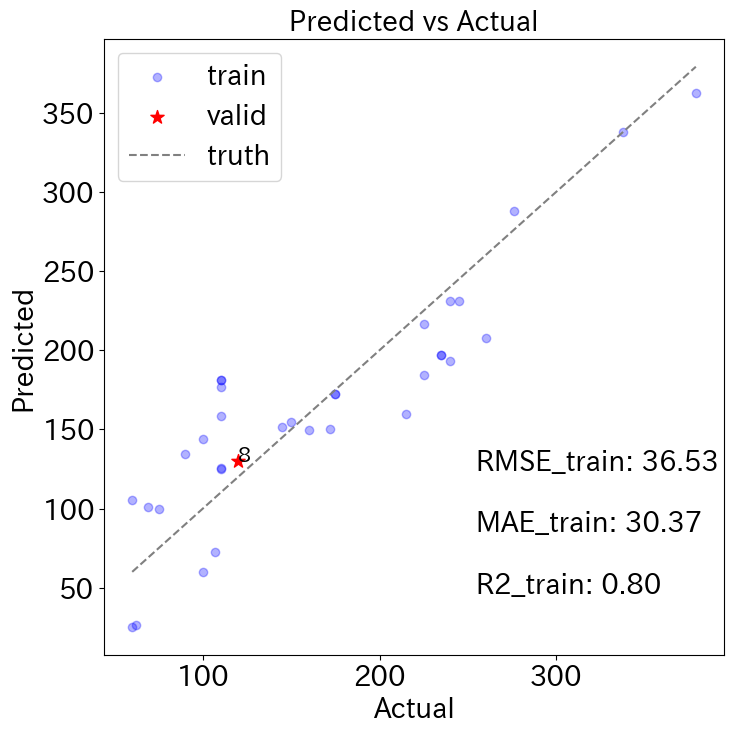

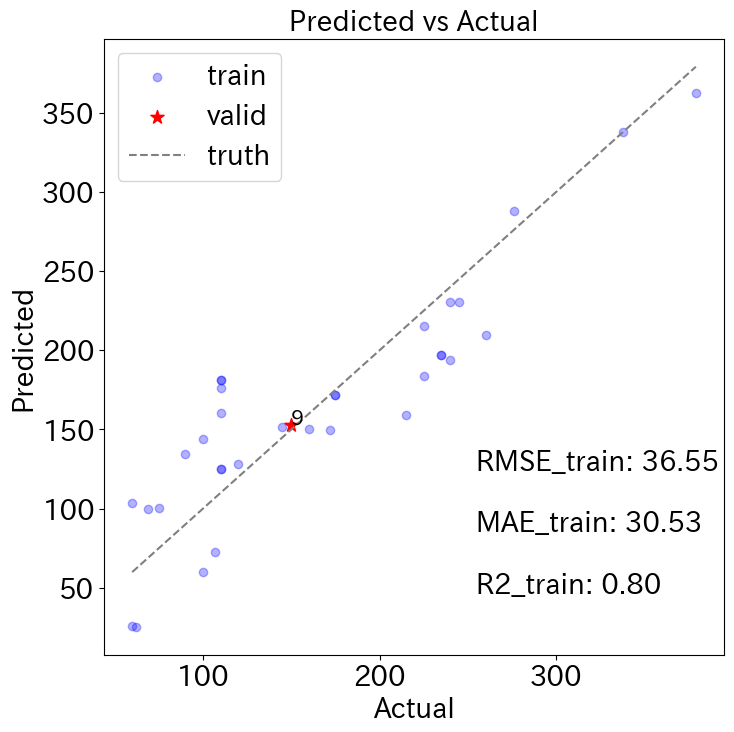

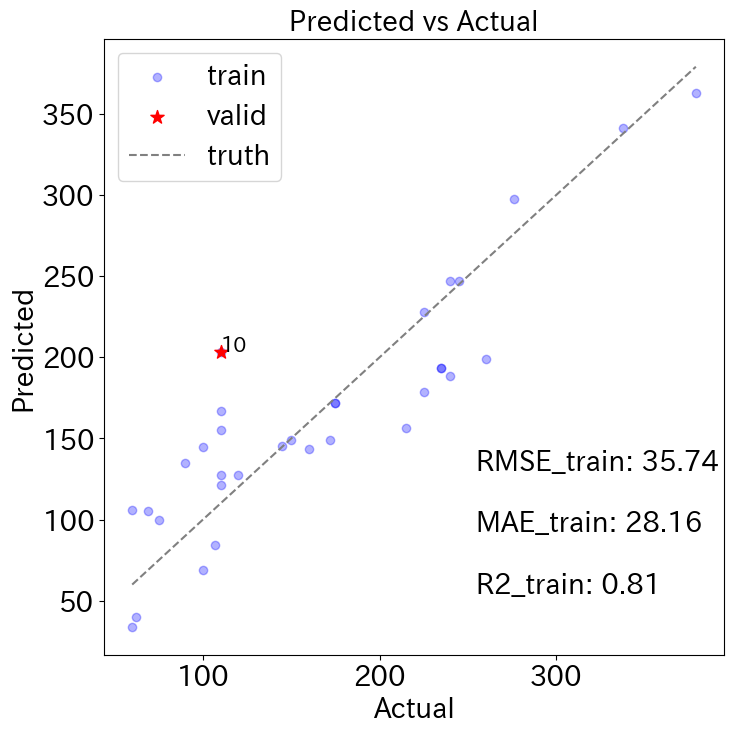

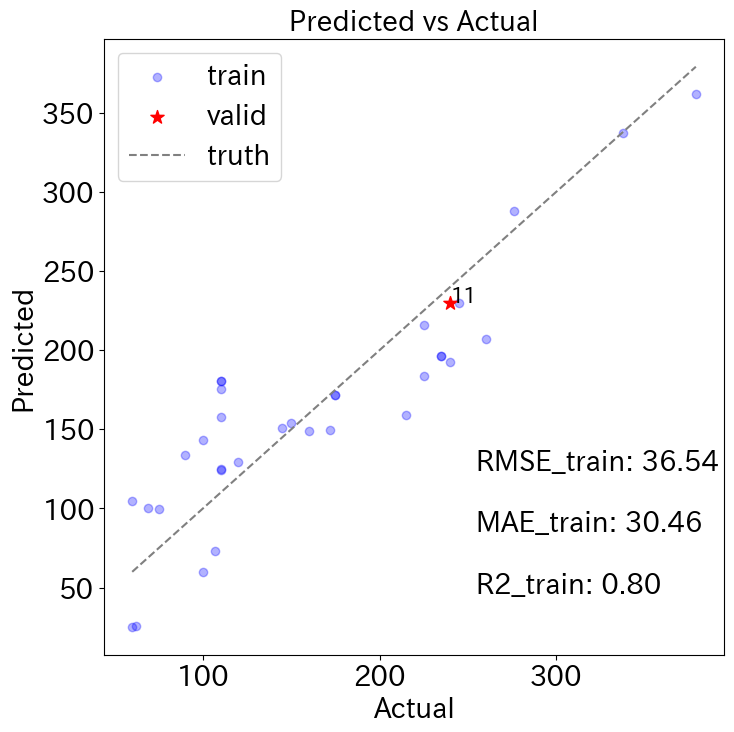

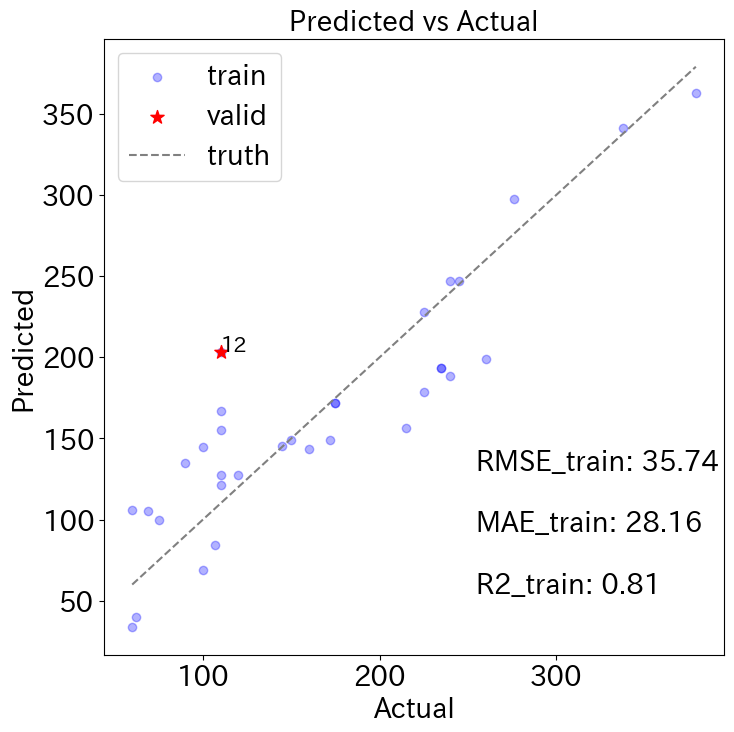

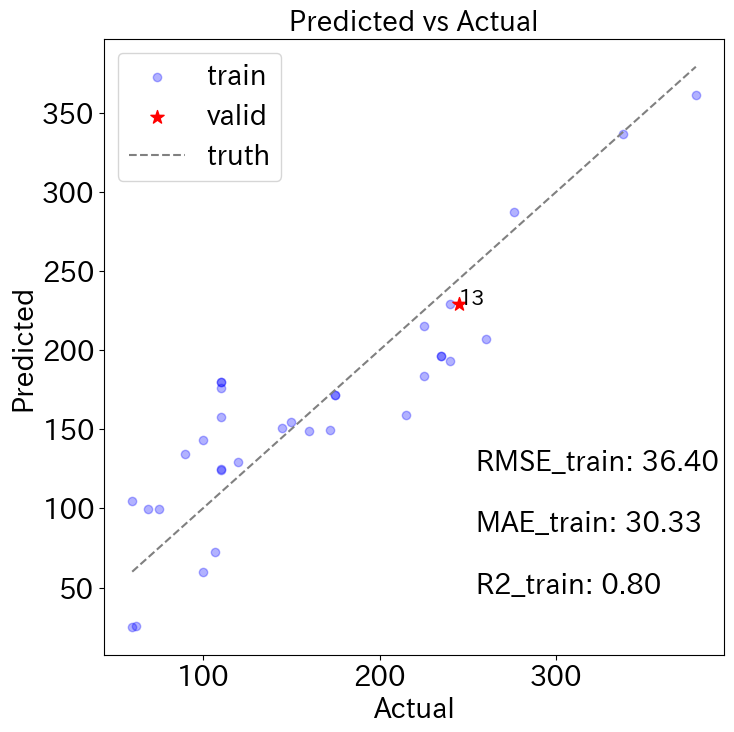

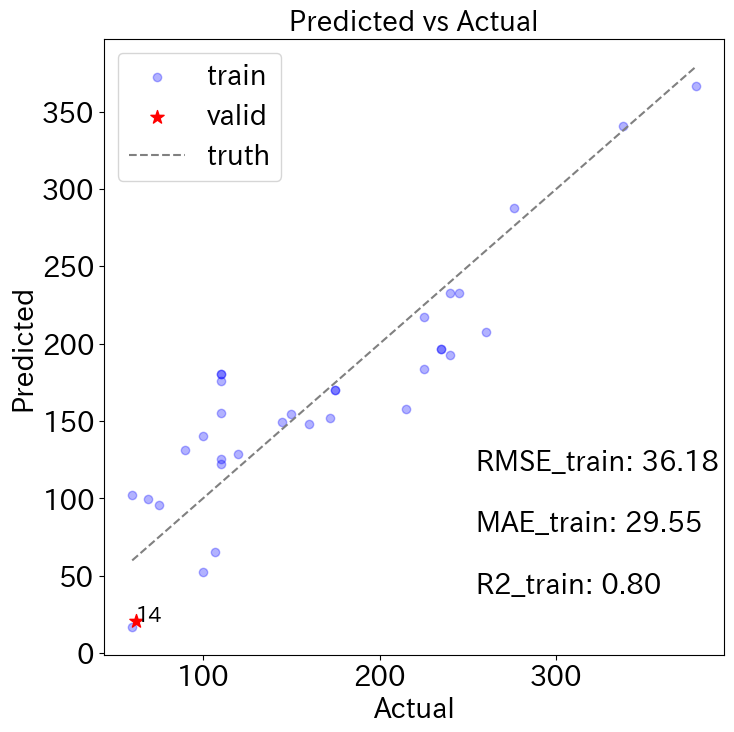

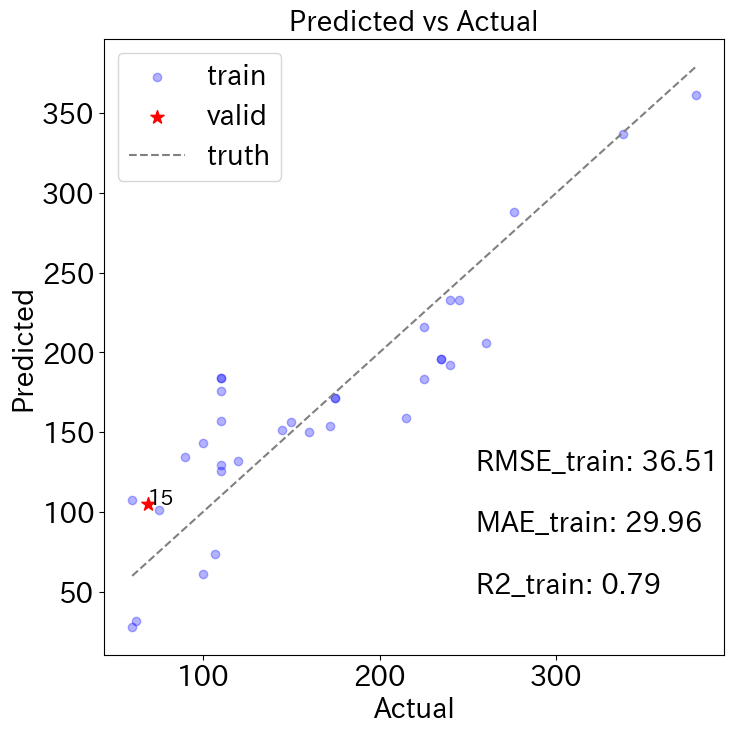

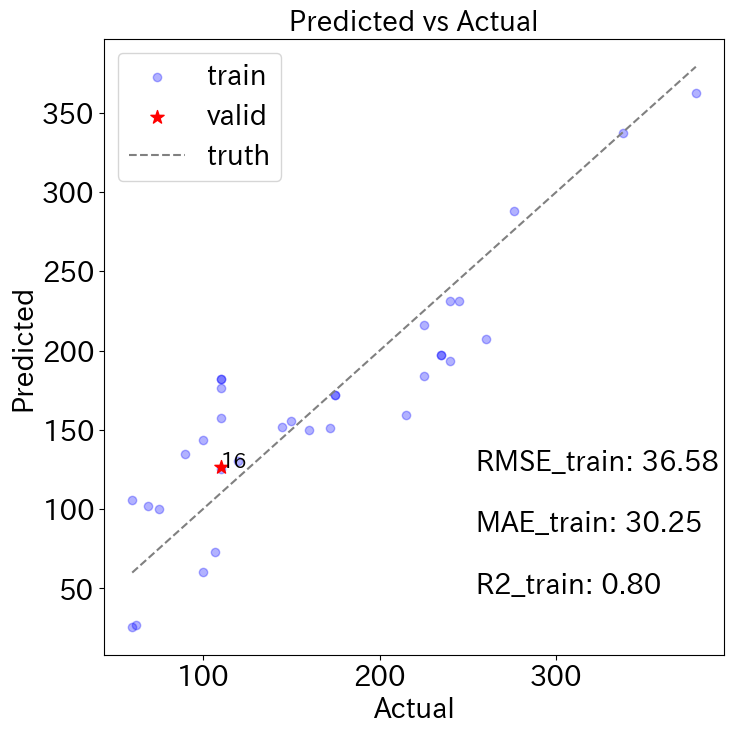

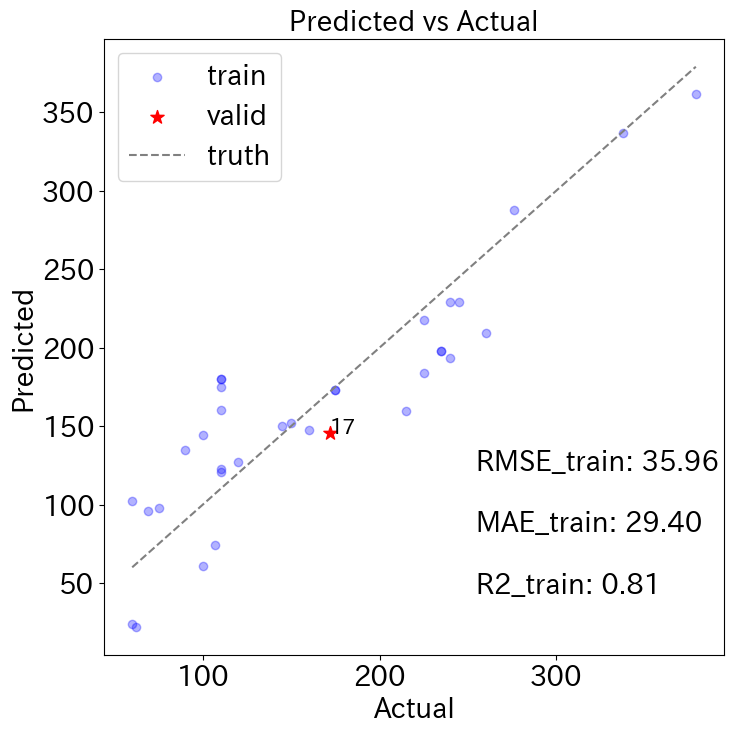

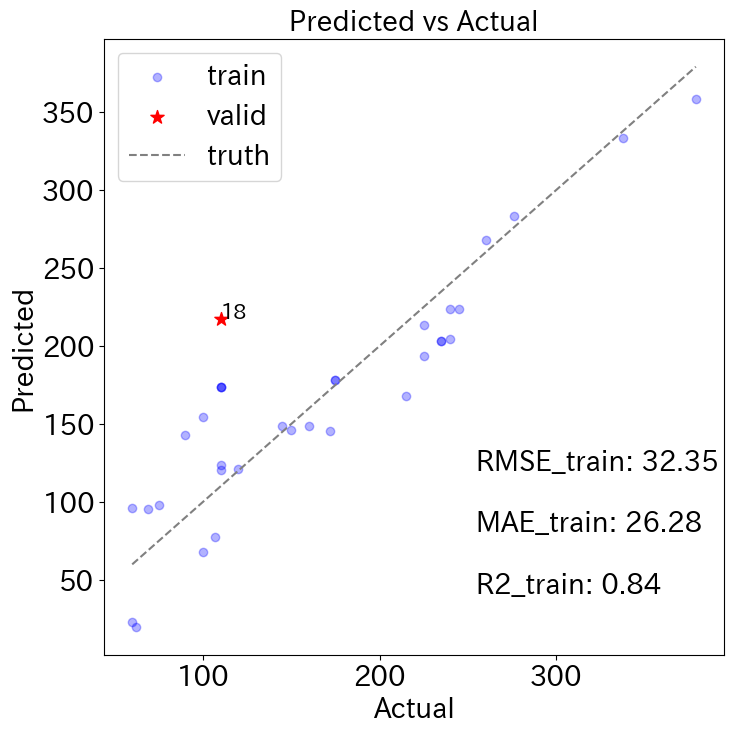

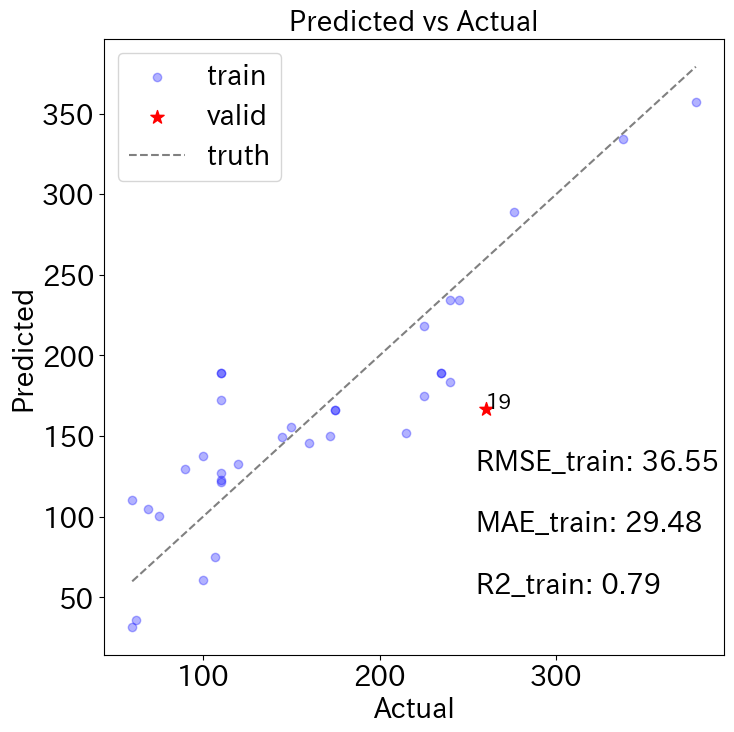

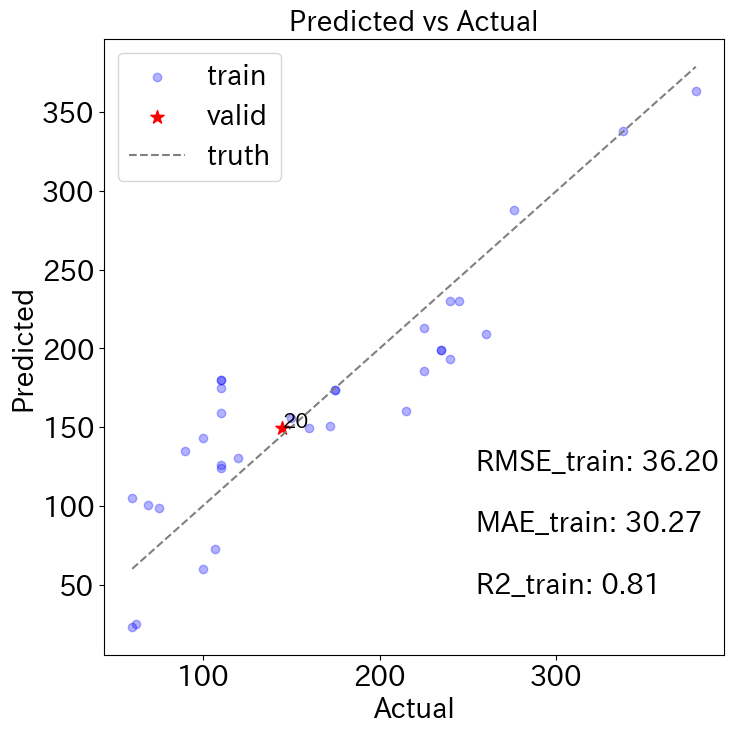

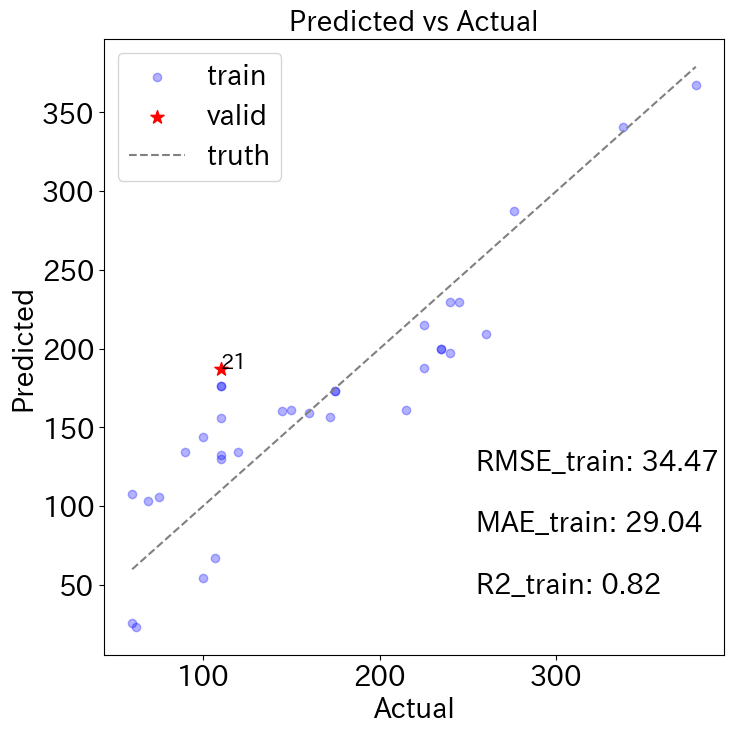

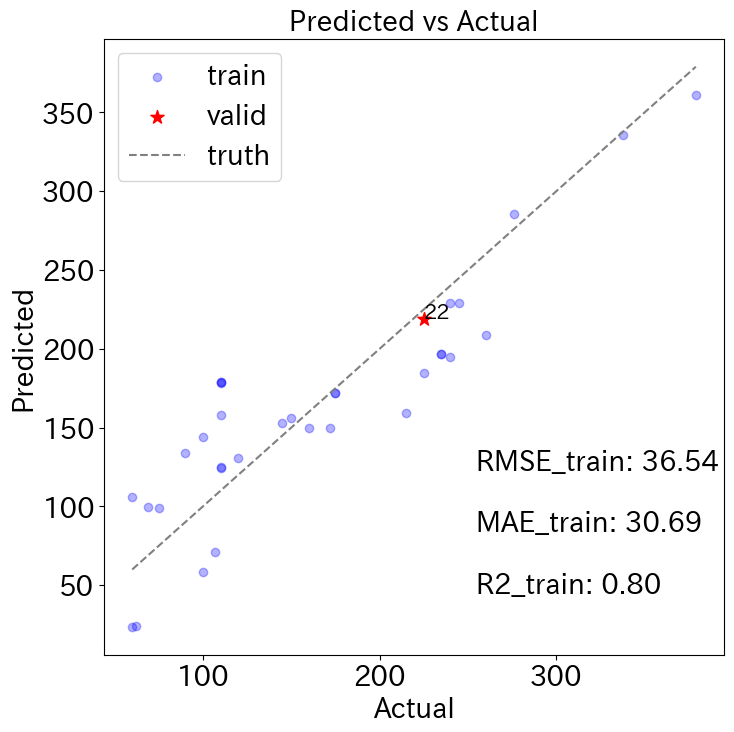

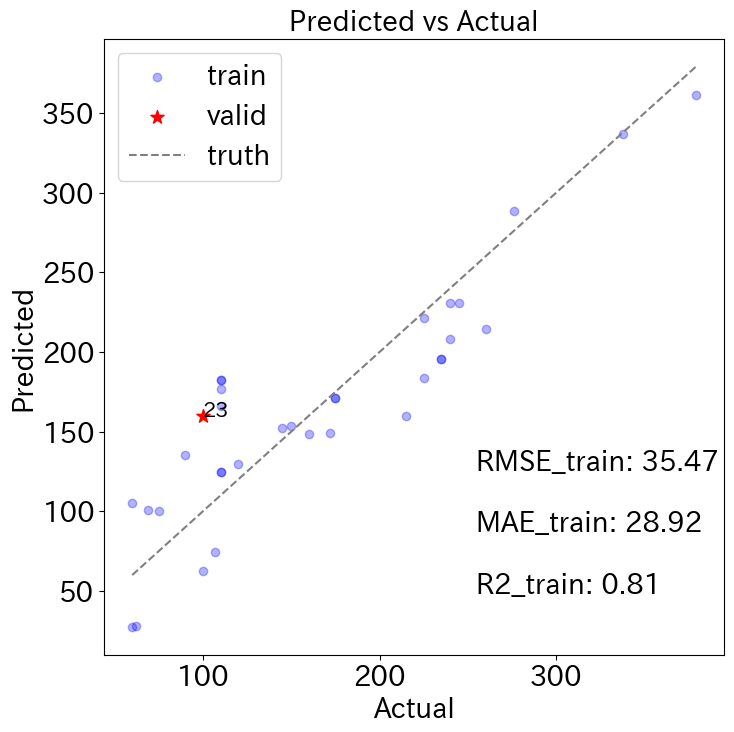

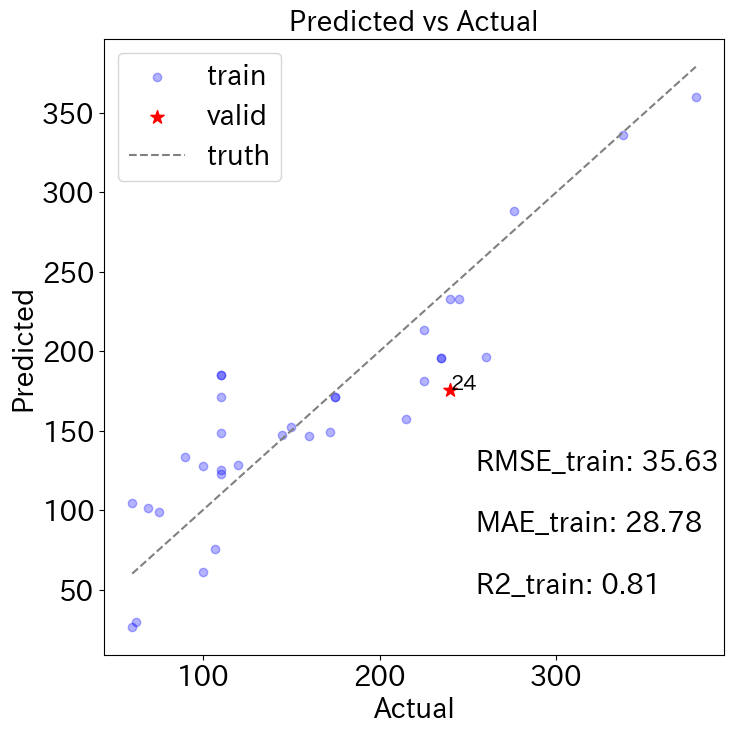

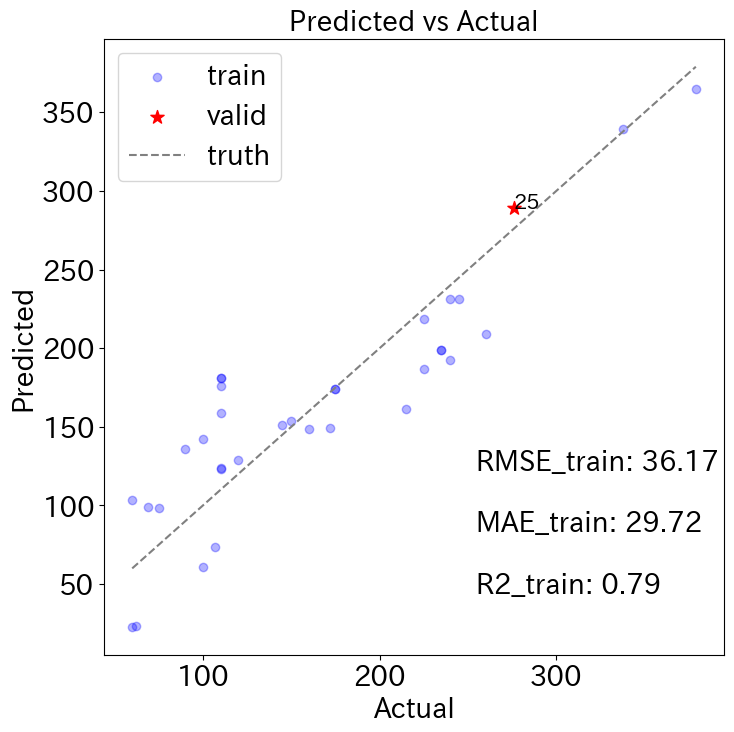

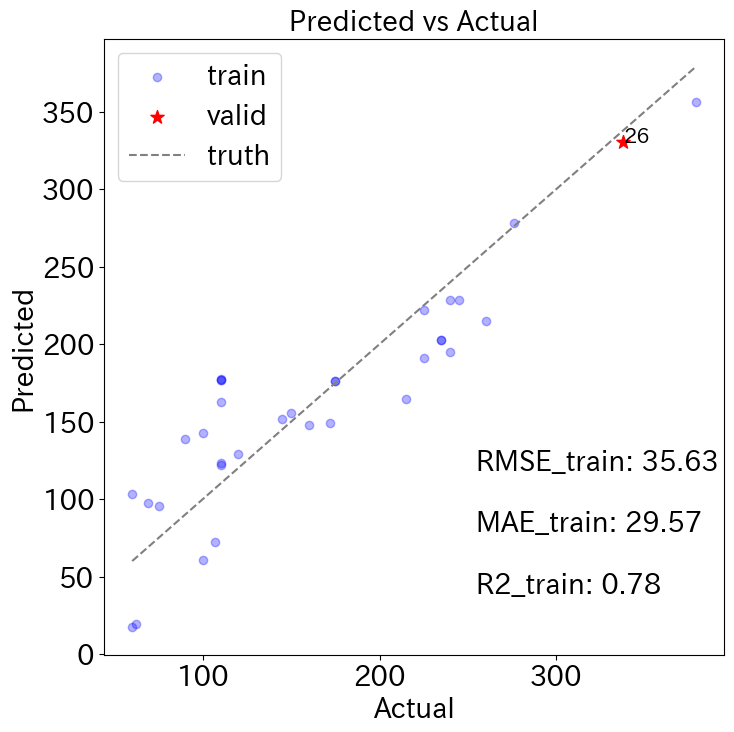

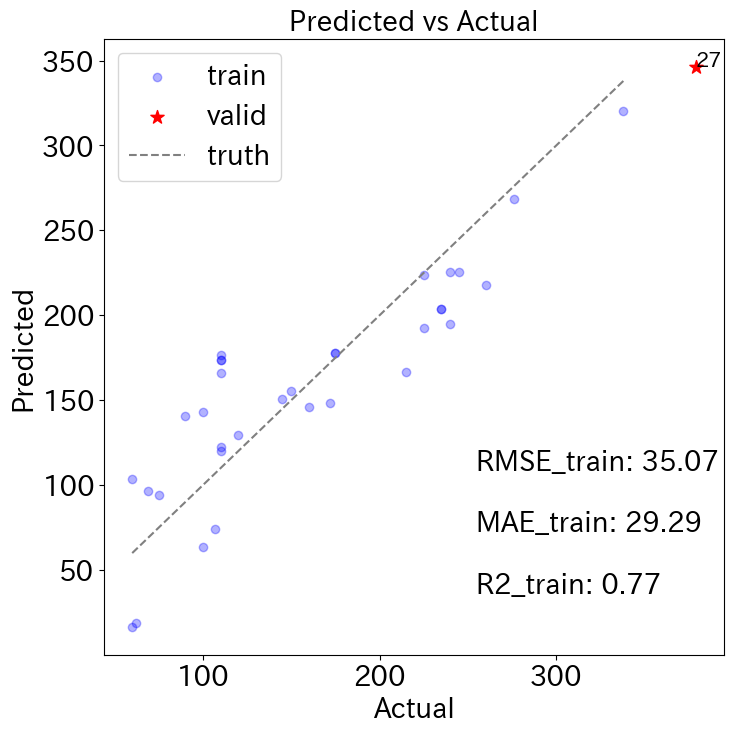

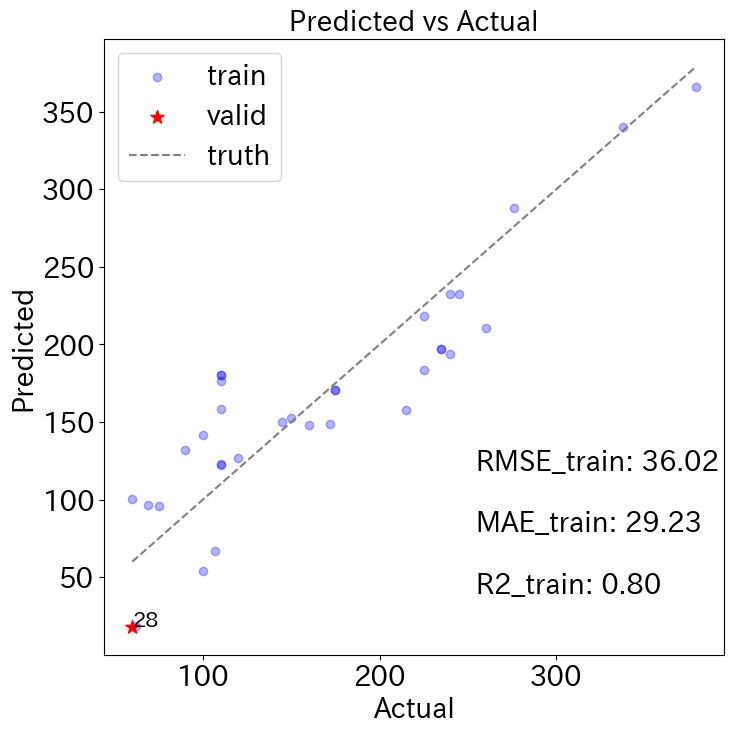

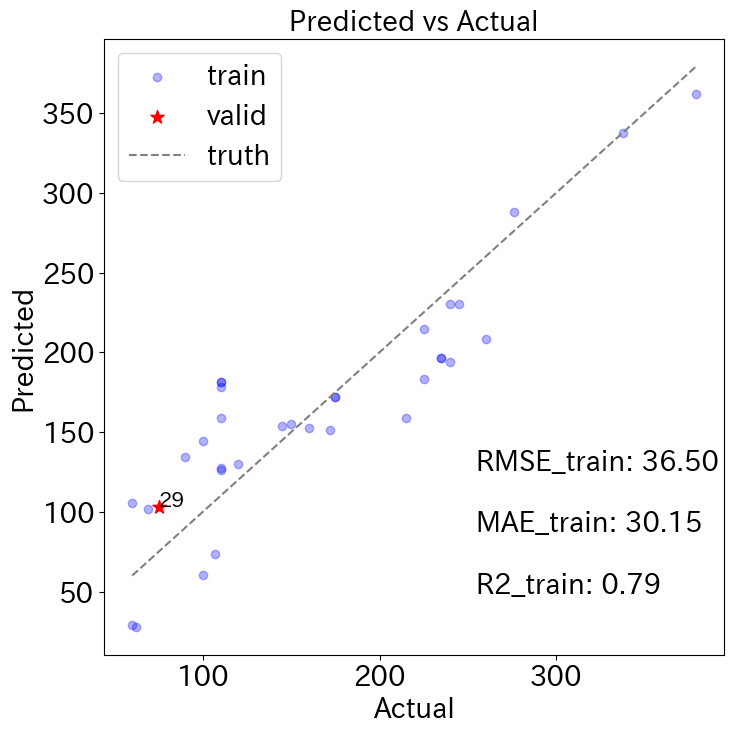

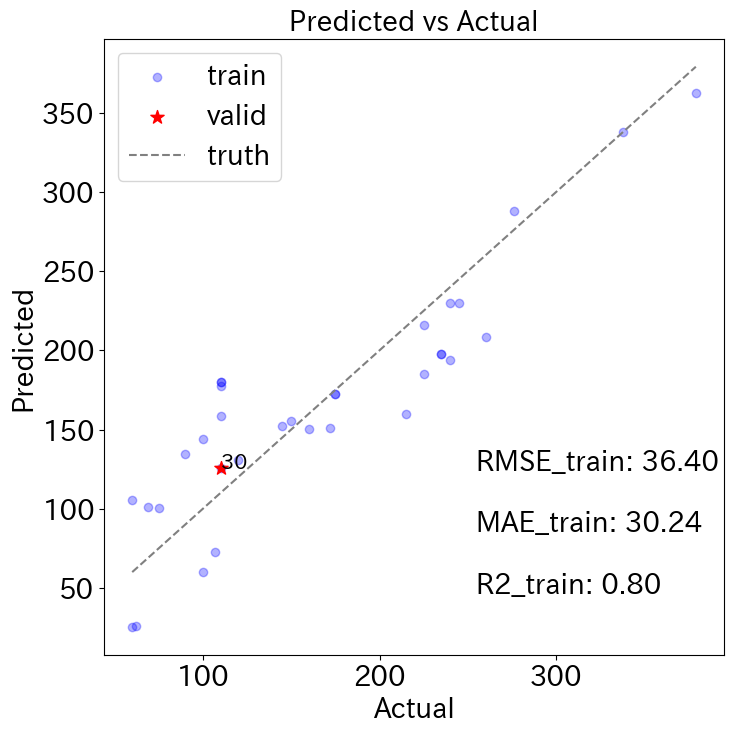

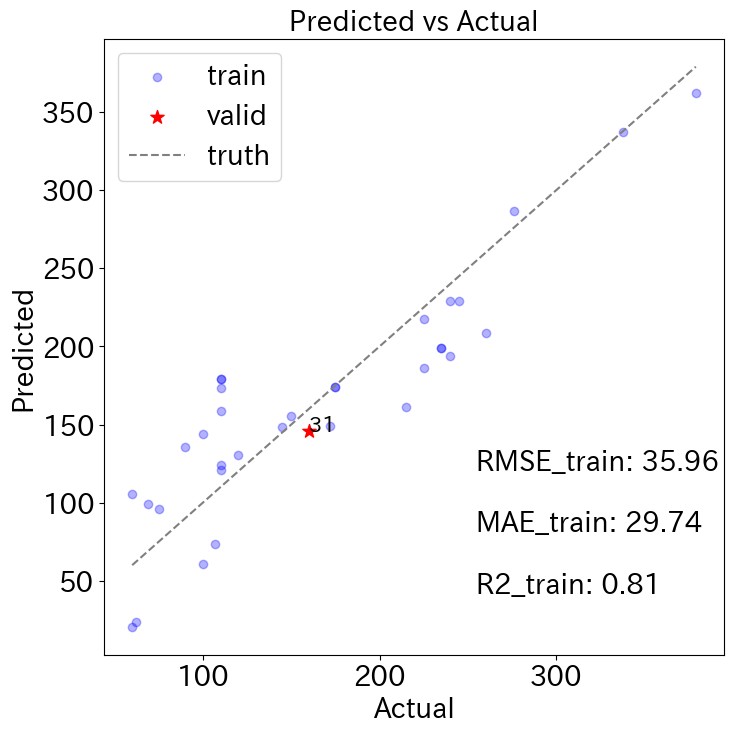

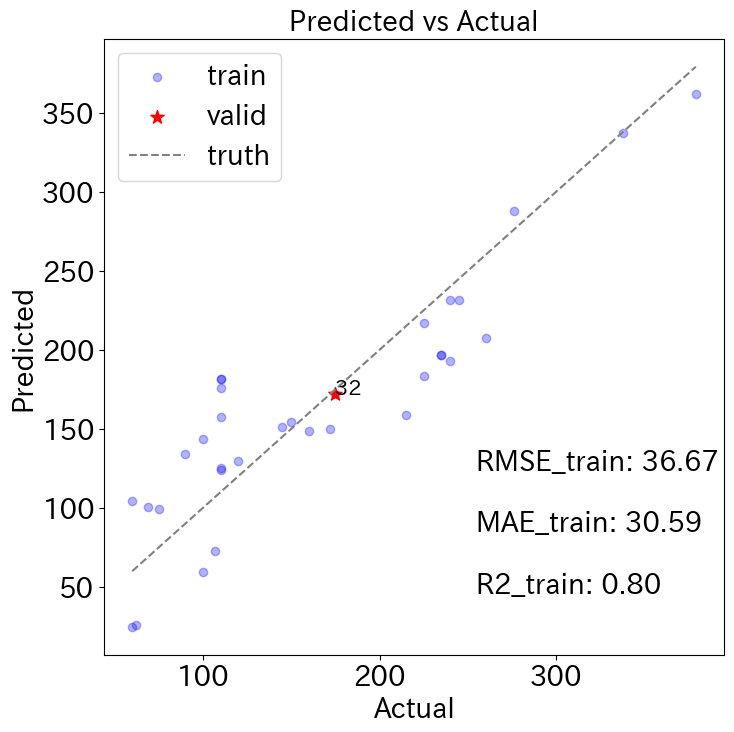

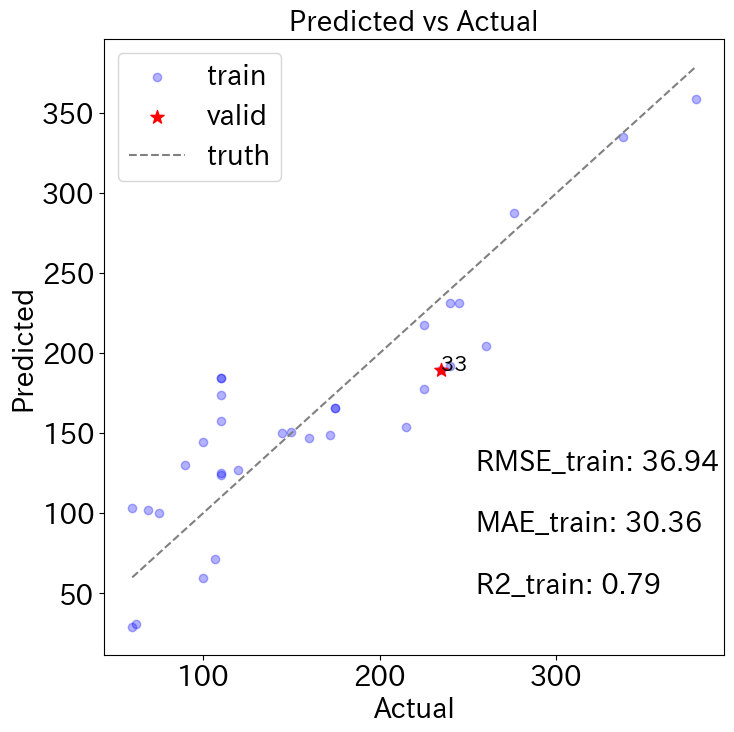

In [15]:
models = []
coef = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PLSRegression(n_components=2)

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    coef.append(model.coef_)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(y_train, y_pred_train, label="train", color="blue", alpha=0.3)
    plt.scatter(y_valid, y_pred_valid, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(y_train.min(), y_train.max() + 1)
    y_truth = x_truth
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(
        0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(data.iloc[valid_index].index):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

### Out-Of-Fold(OOF)のプロット

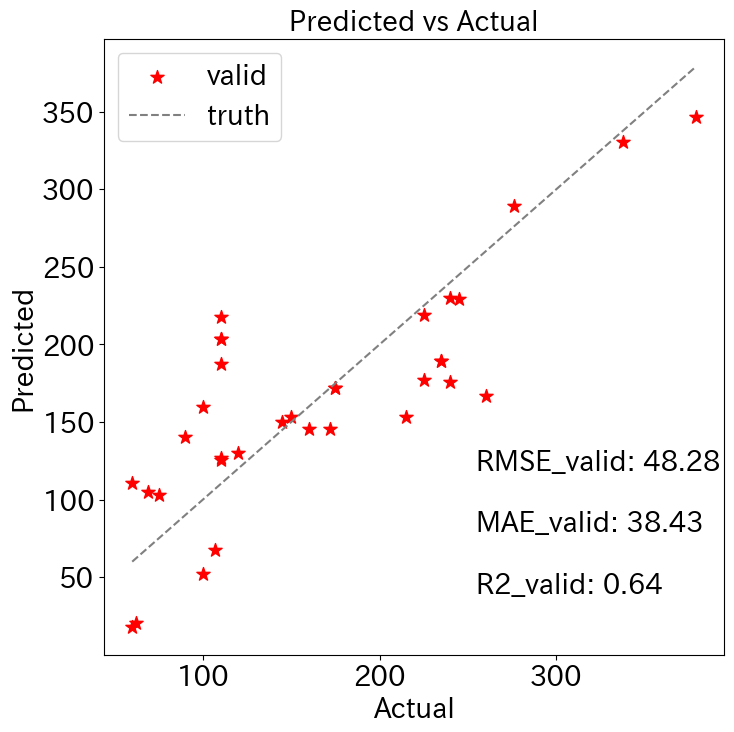

In [16]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
plt.legend()

### Out-Of-Fold(OOF)のプロット&各水準のIDを表示

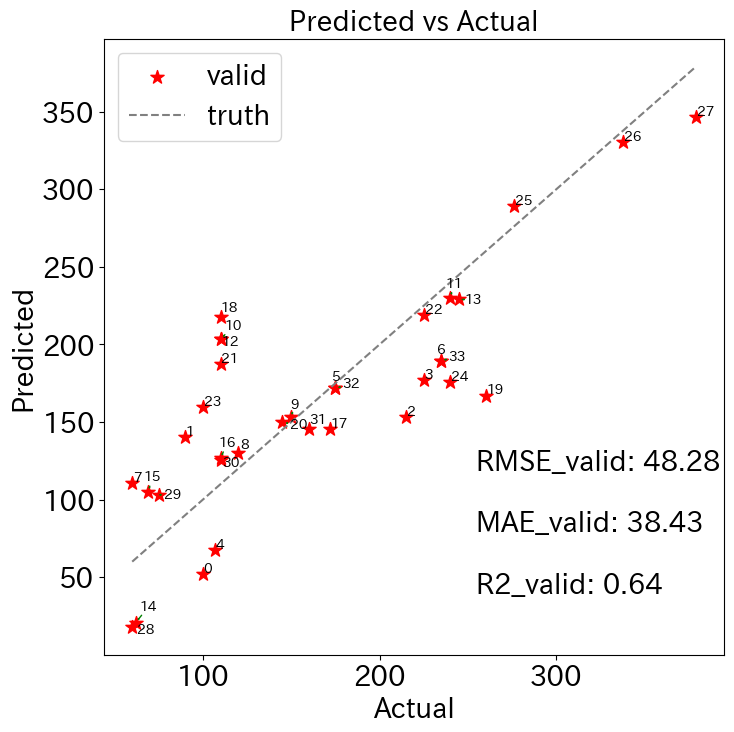

In [17]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(train_Y.values[i], oof[i], data.index[i], fontsize=10)
    for i in range(len(train_Y))
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="green"))
plt.legend()

### Leave-one-outによる各モデルの標準回帰係数の平均を算出

In [18]:
coef = np.array(coef)
coef = np.mean(coef, axis=0)
coef

array([[ 0.56000828,  0.0332182 ,  0.0042888 ,  0.03250638, -0.20204145,
         0.03610923,  0.02077328,  0.20693413, -0.07283173,  0.09972931]])

### 標準回帰係数の平均をデータフレームに格納

In [19]:
coef_df = pd.DataFrame(coef.T, index=numeric_parameter_cols, columns=["coef"])
coef_df

,coef
X,0.560008
Fe (wt%),0.033218
Mn (wt%),0.004289
Si (wt%),0.032506
Al (wt%),-0.202041
Mg (wt%),0.036109
Ti (wt%),0.020773
Cu (wt%),0.206934
Cr (wt%),-0.072832
Zn (wt%),0.099729


### 標準回帰係数の平均のデータフレームを絶対値の降順に並び替え

In [20]:
coef_df = coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)
coef_df

,coef
X,0.560008
Cu (wt%),0.206934
Al (wt%),-0.202041
Zn (wt%),0.099729
Cr (wt%),-0.072832
Mg (wt%),0.036109
Fe (wt%),0.033218
Si (wt%),0.032506
Ti (wt%),0.020773
Mn (wt%),0.004289


### 標準回帰係数の平均をプロットして特徴量重要度として可視化

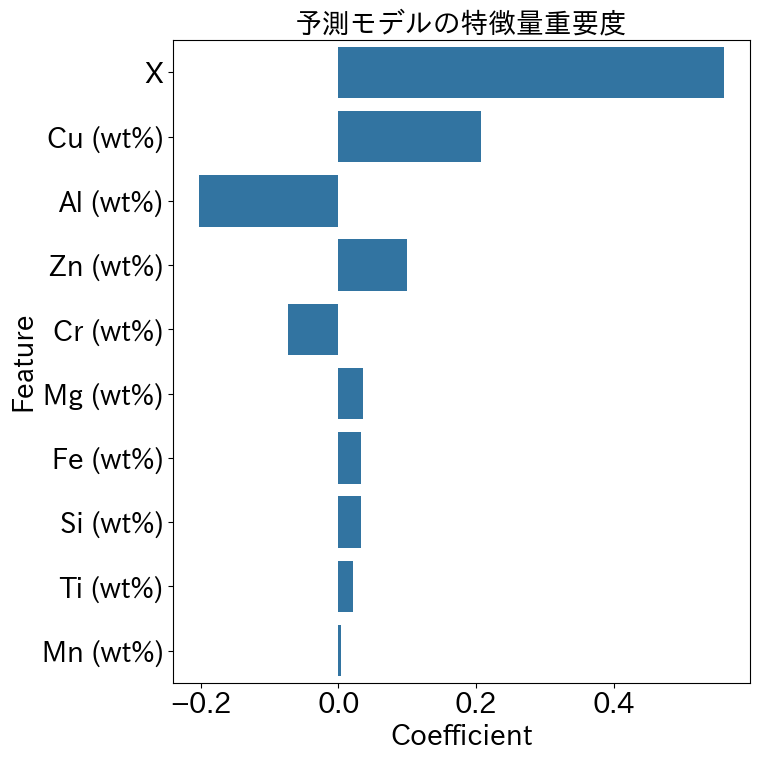

In [21]:
plt.figure(figsize=(8, 8))
sns.barplot(data=coef_df, x="coef", y=coef_df.index)
plt.title("予測モデルの特徴量重要度")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()

### 実行環境の確認及び保存

In [22]:
!python3 -V

Python 3.11.12


In [23]:
!pip freeze > requirements.txt

In [24]:
from google.colab import files

files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>